* * *
<pre> NYU Paris            <i> Machine Learning - Spring 2023 </i></pre>
* * *


<h1 align="center"> Lab: Anomaly detection  </h1>

<pre align="left"> March 22rd 2023               <i> Author: Guillaume Staerman </i></pre>
* * *



Several methods in machine learning can be used to detect fraud or anticipate system failures. While this is a standard -- but very unbalanced -- binary classification problem, it is very hard to find annotated data to perform supervised learning. Moreover, failures are by definition outliers of the general distribution of the data: It may not make any sense to try to "characterize" their distribution specially if new types of anomalies appear. For this reason, we focus in this lab on unsupervised methods for anomaly detection.

# Part I: Probability density estimation

In [9]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Consider the following random variable following a Gaussian (i.e normal) distribution with mean 0 and variance 1.

$$ X\sim \mathcal{N}(0, 1)$$

Its theoretical probability density function is given by:

$$f(x) = \frac{1}{\sqrt{2\pi} }\exp(-\frac{x^2}{2}). $$


### Question 1
Generate 1000 samples from the Gaussian distribution and visualize the histogram on 10 figures with an increasing number of bins. The density function should be overlayed on top to evaluate the quality of the histogram. 

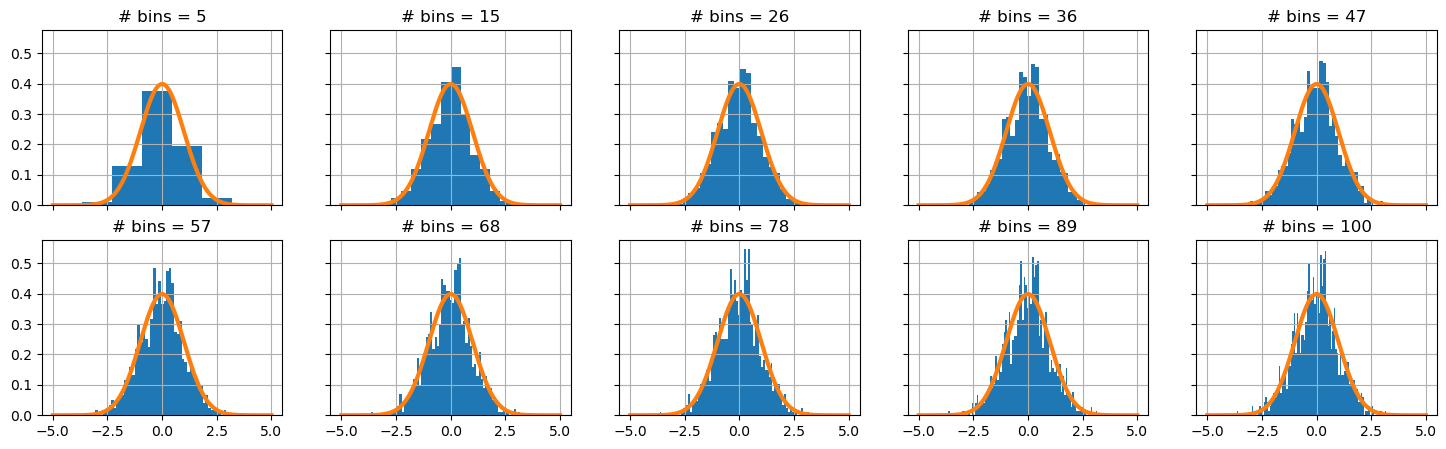

In [10]:
rng = np.random.default_rng(42)
X = rng.normal(size=(1000))
grid = np.linspace(-5, 5., 1000)
density = np.exp(- grid ** 2 / 2) / (2 * np.pi) ** 0.5

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)
for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density, lw=3)
    ax.grid(True)
plt.show()

### Question 2

Histograms approximate the density by counting the number of samples falling in a bin, regardless of where the sample falls withing that bin. To better approximate the density, one can instead count the samples but with a given weight: samples falling in the center of the bin should count more than samples on the edges of the same bin. This weighting can be decided by a Kernel function: enters the Kernel density estimator.

Compare (graphically) the density estimaton of KDE to that of a histogram. 


_Hints:
The Kernel density object can be fitted on some data X (n_samples, dimension):
`kde.fit(X)`
then evaluated on some points to obtain the logarithm of the density funciton values: `kde.score_samples(X_eval)`_
(i.e the log-likelihood).

In [11]:
from sklearn.neighbors import KernelDensity
import math

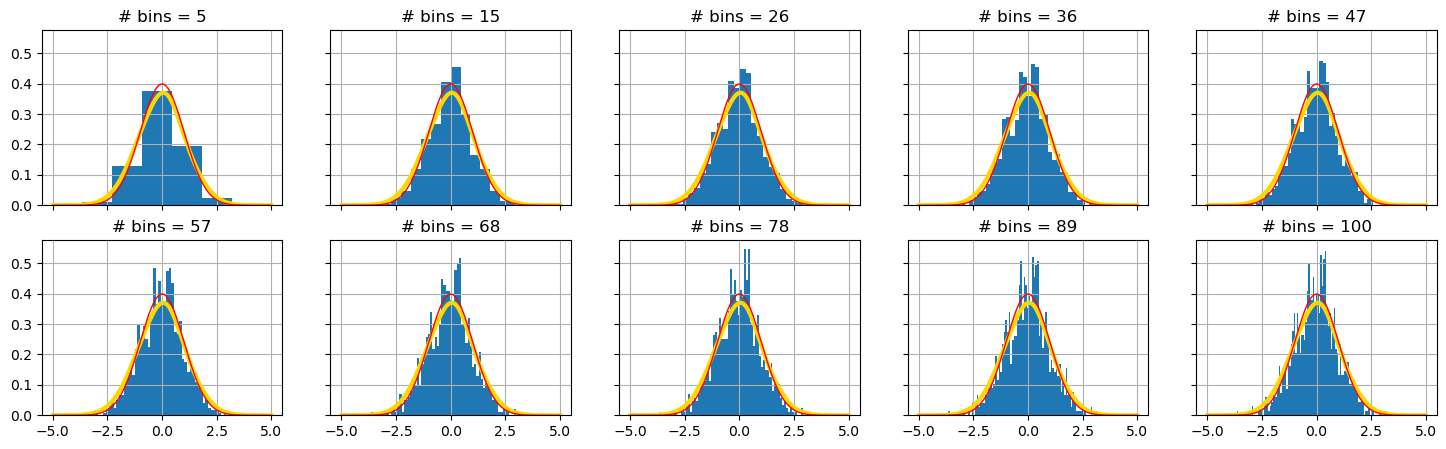

In [12]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

logdensity_kde = kde.score_samples(grid[:, None])

e = 2.7182818284

density_kde = e**logdensity_kde

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)

for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density_kde, color="gold", lw=3)
    ax.plot(grid, density, color="red", lw=1)
    ax.grid(True)

plt.show()

### Question 3
Contaminate the samples by adding very large values. How did their kde score change ? How can this log-likelihood score be used to detect outliers ?

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   4.,   0.,   2.,
          6.,   6.,  11.,  20.,  35.,  58.,  89., 187., 579.]),
 array([-7.13354663, -6.82664734, -6.51974805, -6.21284876, -5.90594947,
        -5.59905017, -5.29215088, -4.98525159, -4.6783523 , -4.37145301,
        -4.06455372, -3.75765442, -3.45075513, -3.14385584, -2.83695655,
        -2.53005726, -2.22315797, -1.91625868, -1.60935938, -1.30246009,
        -0.9955608 ]),
 <BarContainer object of 20 artists>)

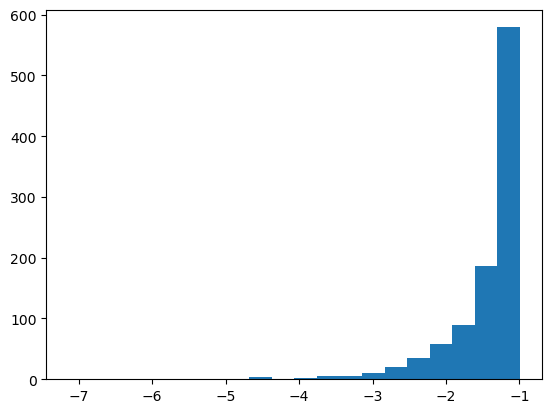

In [13]:
X[0] = 200000.
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

logdensity_kde = kde.score_samples(X[:, None])
plt.hist(logdensity_kde, bins=20)


By contaminating the dataset with a very large value A, we are increasing the total sum of distances for every datapoint in the dataset. Also, the sum of distances from A is a value much greater than the sum of distances of the other values. This results in the likelihood of the dataset to decrease (the histogram "compresses"). And so the log likelihood values become more negative.

When running the cell above, we indeed observe this. We notice that we are changing a value (X[0]) rather than just adding it.

The log likelihood is, by design, a measure of how likely a datapoint is as the observation of a distribution. So, very negative values are indicators of anomalies in the dataset. 

In [14]:
X[np.where(logdensity_kde < -5)[0]]

array([ 2.00000000e+05,  3.17885368e+00, -3.64841283e+00])

### Question 4
We are now ready to move on to a 2-dimension setting. We generate some data:

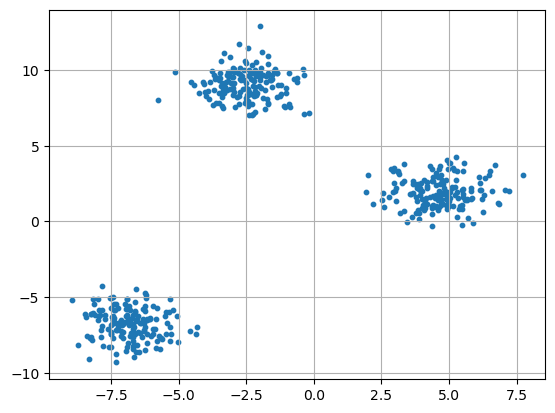

In [15]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.grid()
plt.show()

The function `plot_logdensity` displays the density estimation contours.

In [16]:
def get_2d_grid(X):
    n_samples, n_features = X.shape
    X_range = np.zeros((n_features, 2))
    X_range[:, 0] = np.min(X, axis=0) - 1.
    X_range[:, 1] = np.max(X, axis=0) + 1.

    h = 0.1  # échelle de la grille
    x_min, x_max = X_range[0]
    y_min, y_max = X_range[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_logdensity(kde, X):
    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    scores = kde.score_samples(grid).reshape(xx.shape)
    plt.figure()
    z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) # on trace les level sets de oneclass svm
    plt.scatter(X[:, 0], X[:, 1], s=5)
    plt.colorbar(z)
    plt.title("Log-density")
    plt.show()

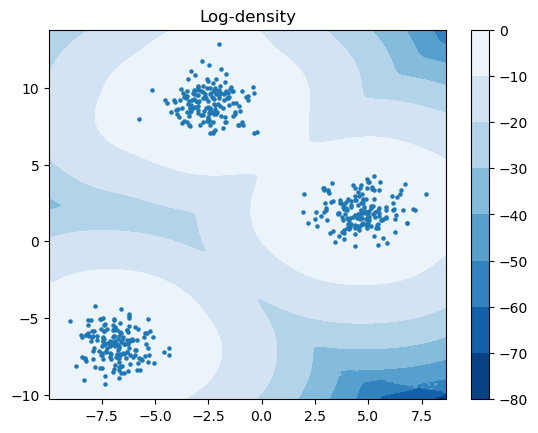

In [17]:
kde = KernelDensity(kernel='gaussian', bandwidth=1.)
kde.fit(X)
plot_logdensity(kde, X)

In [18]:
## figure left here for "spiking curiosity purposes"

We can visualize a specific contour of the density by providing a `levels` argument in `plt.contour`. Using this  code below.

<a list of 9 text.Text objects>

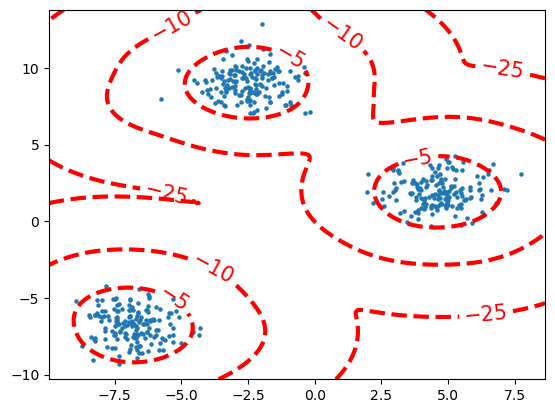

In [19]:
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = kde.score_samples(grid).reshape(xx.shape)
somevalue = [-25, -10, -5]
plt.scatter(X[:, 0], X[:, 1], s=5)
c_0 = plt.contour(xx, yy, scores, levels=somevalue, colors='red', linewidths=3)
## add a label to this specific contour
plt.clabel(c_0, inline=1, fontsize=15)

The mquantiles function returns the value of the quantile q of some empirical distribution. Use `mquantiles` to decide an outlier threshold value and display its contour using the code above by adding it to `plot_logdensity` function. How does the contour change with the chose value ? 

In [20]:
from scipy.stats.mstats import mquantiles

logdensity_scores = kde.score_samples(X).ravel()
threshold = mquantiles(logdensity_scores, 0.02)

In [21]:
def plot_logdensity(X, bandwidth=1., quantile=0.01, subplot=None):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)
    logdensity_scores = kde.score_samples(X)
    threshold = mquantiles(logdensity_scores, quantile)

    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scores = kde.score_samples(grid).reshape(xx.shape)
    
    if subplot:
        plt.subplot(*subplot)

    z = plt.contourf(xx, yy, grid_scores, cmap=plt.cm.Blues_r)
    plt.scatter(X[:, 0], X[:, 1], s=5)
    
    c_0 = plt.contour(xx, yy, grid_scores, levels=[threshold[0]], colors='red', linewidths=3)
    plt.clabel(c_0, inline=1, fontsize=15, fmt={threshold[0]: str(quantile)})
    plt.title(f"Quantile = {quantile}")


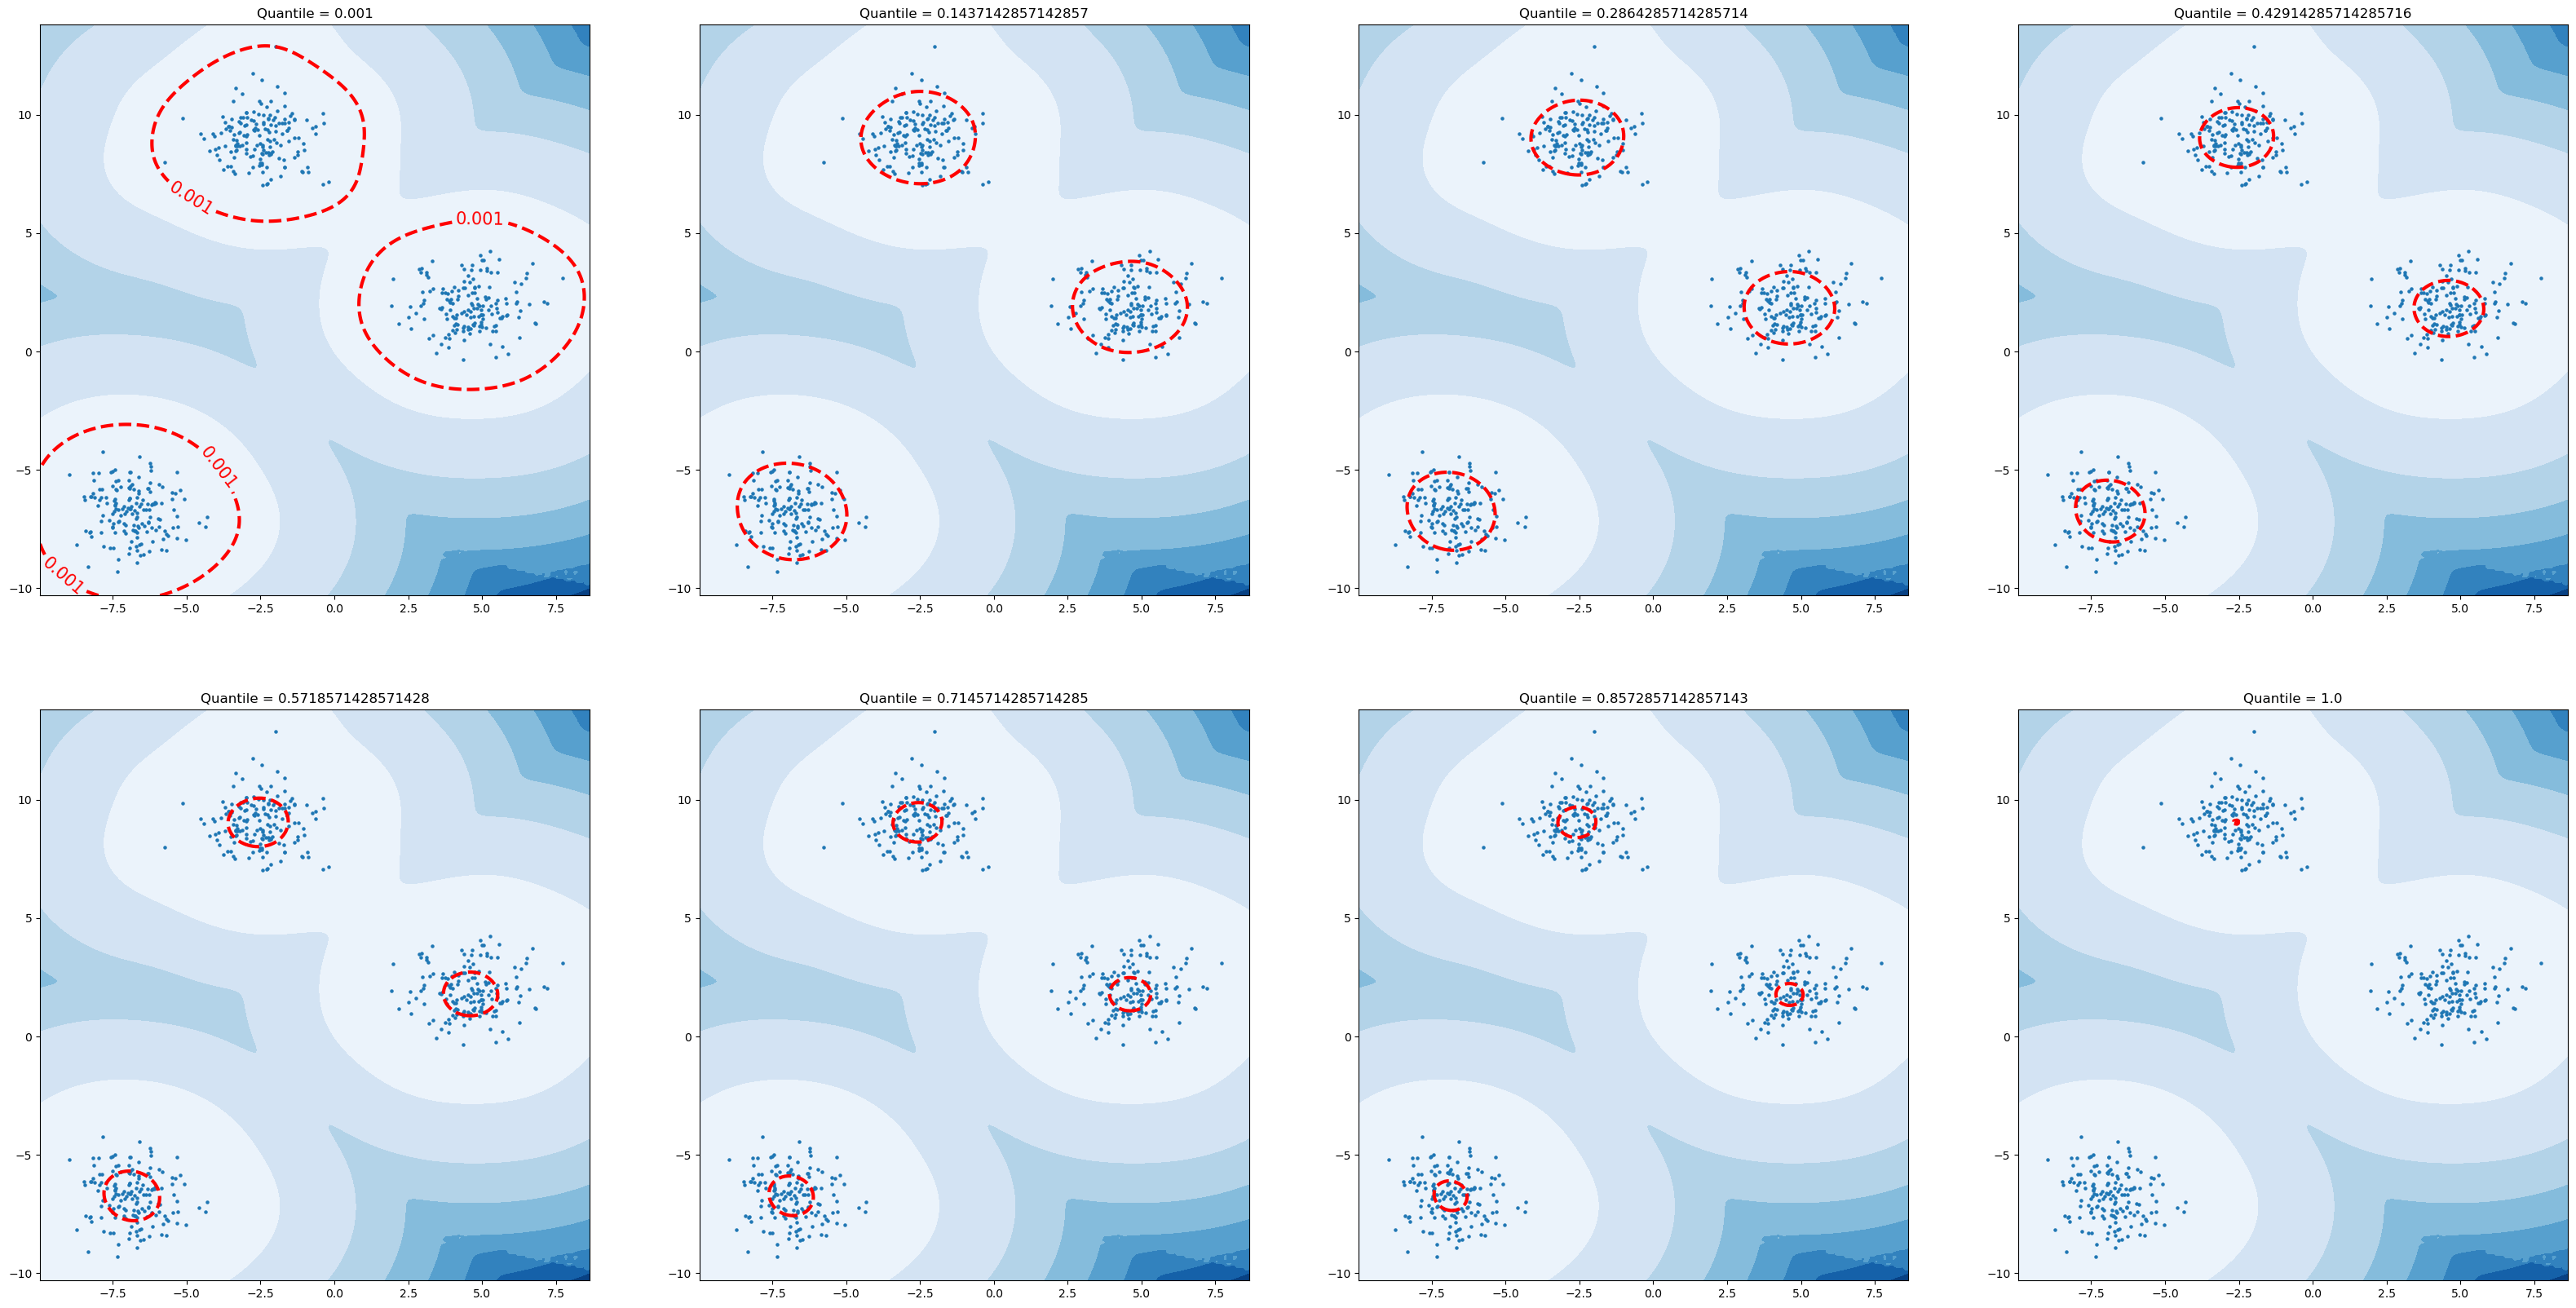

In [22]:
fig = plt.figure(figsize=(40, 20))
quantiles = np.linspace(0.001, 1, 8)
for quant, i in zip(quantiles, range(8)):
    plt.subplot(2, 4, i+1)
    plot_logdensity(X, quantile = quant, subplot=(2, 4, i+1))
    
plt.axis('on')
plt.show()

We can observe that the decision boundaries reduce in diamater as we increase the quantile value. This is to be expected. The quantile represents what portion of the values we are trying to exclude from the "standard behavior." Therefore, if we increase the value, more points will be excluded. 

# Part 2: OneClass SVM

The SVM intuition can be used for novelty detection even for unsupervised learning. The idea is to find a separation in a higher dimensional space that contains most of the data. Intuitively, using a Gaussian kernel for example, we are looking for the smallest hypersphere  that contains the data. This minimization with the flexibility of allowing some samples (outliers) to be out of the sphere, leads to an outlier detection model.

In [23]:
from sklearn.svm import OneClassSVM
nu = 0.05  # regularization parameter controlling the max proportion of expected outliers
gamma = 'scale'
ocsvm = OneClassSVM(nu = nu)

###  Question 5

Draw the frontier (separation) of the oneclass svm using `ocsvm.decision_function`. Use the predict function to get outliers detected by OCSVM and visualize them on top. 

In [24]:
# to do
ocsvm.fit(X)
X_pred = ocsvm.predict(X)
X_normal = X[X_pred == 1]
X_outliers = X[X_pred == -1]


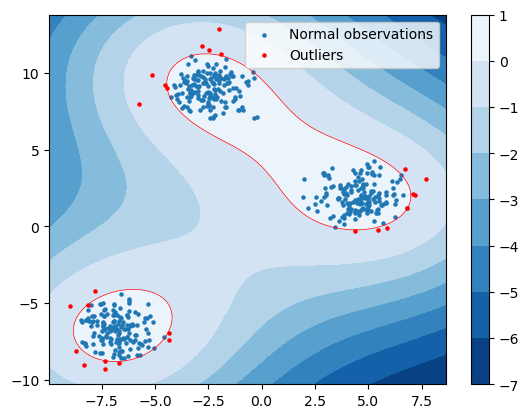

In [25]:
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = ocsvm.decision_function(grid).reshape(xx.shape)
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
c_0 = plt.contour(xx, yy, scores, levels=[0], colors='red', linewidths=0.5)
plt.colorbar(z)
plt.legend()
plt.show()

### Question 6
Run the following cell. What can we say about the support vectors of the OCSVM ?



In [28]:
X_SV = X[ocsvm.support_] 
n_SV = len(X_SV)
print(f"Number of support vectors = {n_SV}")


n_outliers = len(X_outliers)
print(f"Number of outliers = {n_outliers}")

counter = 0
for sv in X_SV:
    if sv in X_outliers:
        counter += 1
print(f"Number of support vectors and outliers = {counter}")

Number of support vectors = 28
Number of outliers = 26
Number of support vectors and outliers = 26


We can observe that all but 2 support vectors of the ocsvm are also the datapoints classified as outliers. We expect this as the support vectors influence the boundaries of a support vector machine. And, we are preisely building the boundary to detect outliers. Given that we have 28 SVs and 1000 datopoints, we can assess that the SVM is complex enough to deal with the data sepaartion and anomaly detection. 

### Question 7

What is the expected effect of the choice of `nu` ? `gamma`? Visualize the separation and the detected outliers in a large 2d plt.subplots where each parameter is modified along one of the subplots axes. 

Nu is defined in scikit learn as "an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors." We saw that the cardinality of the support vectors is almost equivalent to the number of outliers. So, as we increase nu, we expect to see more and more outliers (the decision boundary reduces in area).

Gamma roughly represents how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. Hence, we expect the kernel function to behave 'locally' with higher values, and 'globally' with lower. Formally, gamma is a hyperparameter of the gaussian kernel: $exp(-\gamma\frac{|x-y|^2}{2\sigma^2})$. When $\gamma$ is large, our kernel approximates linearity (which translates in smooth elipsis), while higher values imply more non-linear boundaries.

In [19]:
def plot_svm(X, nu, gamma):
    ocsvm = OneClassSVM(nu = nu, gamma = gamma)
    ocsvm.fit(X)
    X_pred = ocsvm.predict(X)
    X_normal = X[X_pred == 1]
    X_outliers = X[X_pred == -1]

    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    scores = ocsvm.decision_function(grid).reshape(xx.shape)

    z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
    plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
    plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
    c_0 = plt.contour(xx, yy, scores, levels=[0], colors='red', linewidths=0.5)


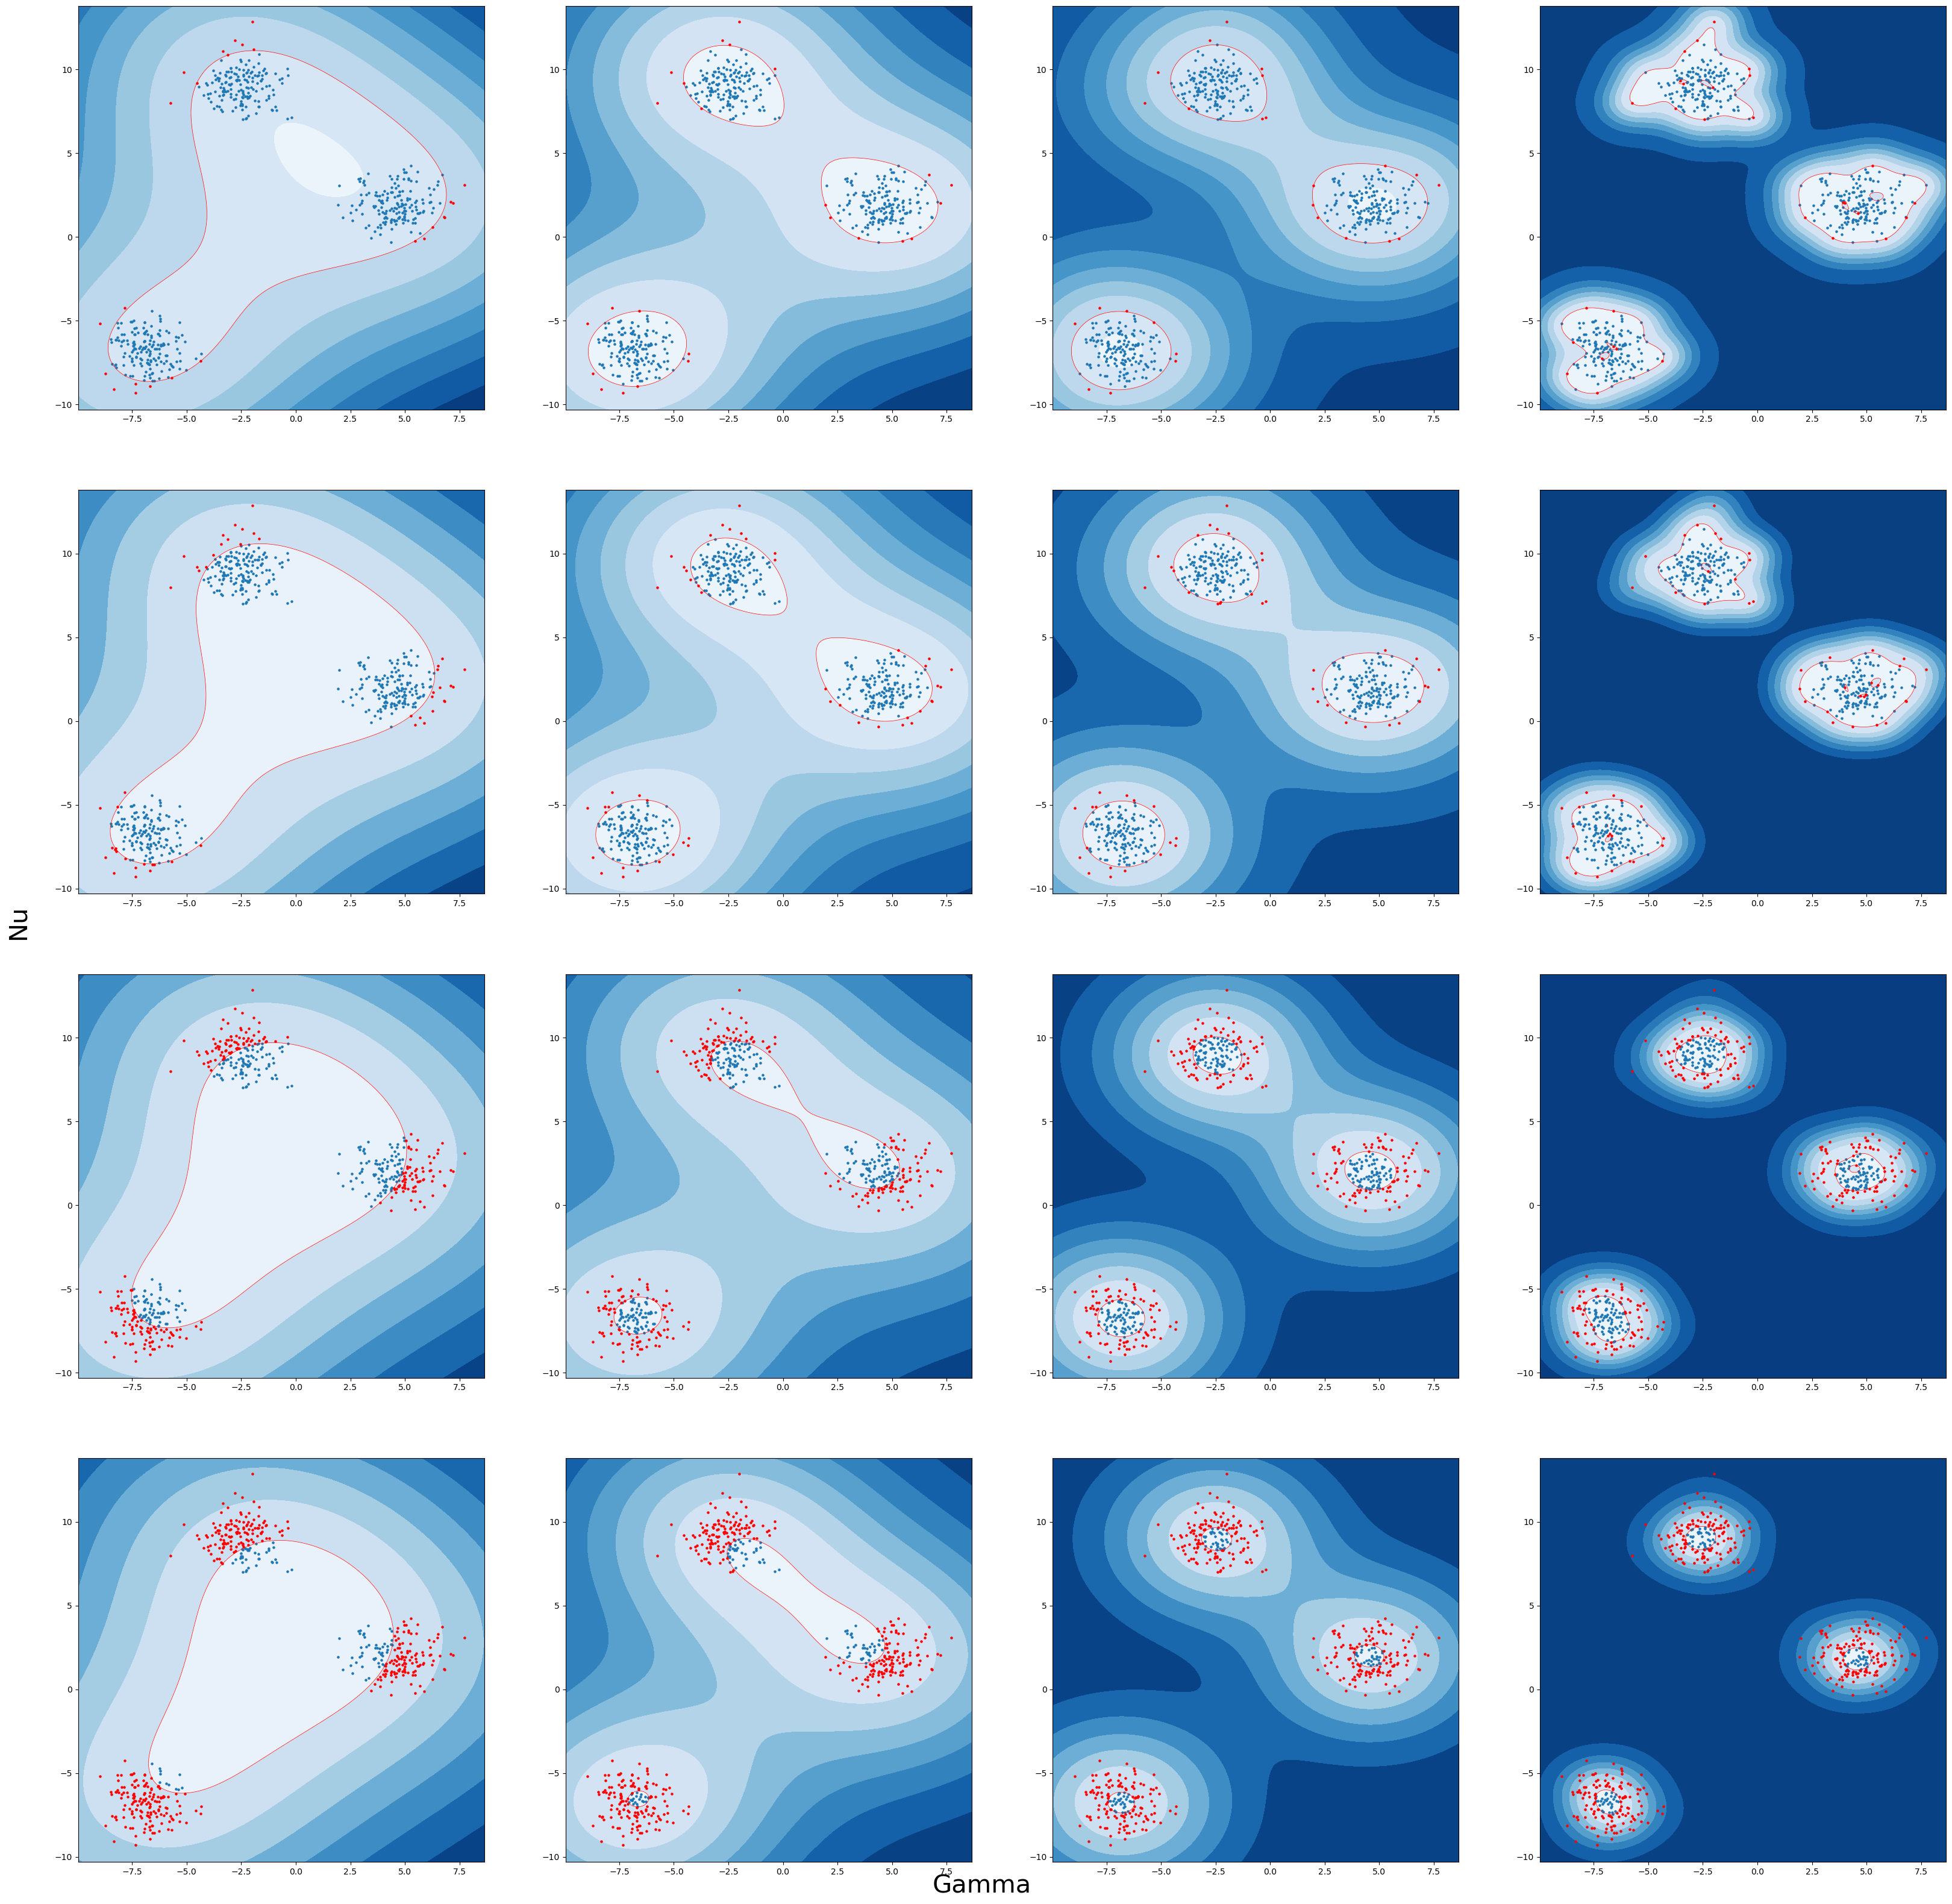

In [20]:
nus= [0.05, 0.1, 0.5, 0.8]
gammas= [0.01, 0.02, 0.05, 0.5]

fig = plt.figure(figsize=(40, 40))

for i in range(4):
    for j in range(4):
        k = i*4 + j
        plt.subplot(4, 4, k+1)
        plot_svm(X, nu=nus[i], gamma=gammas[j])
fig.text(0.5, 0.1, 'Gamma', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Nu', ha='center', va='center', rotation='vertical', fontsize=30)
plt.show()

# Part 3: Isolation Forest

In [30]:
from sklearn.ensemble import IsolationForest

### Question 8

Use Isolation Forest on the data and draw contours of the IF scores. Is it equivalent to those of the density? Contours should be simlar to hyper-rectangle if the number of trees is low (<10), why ?

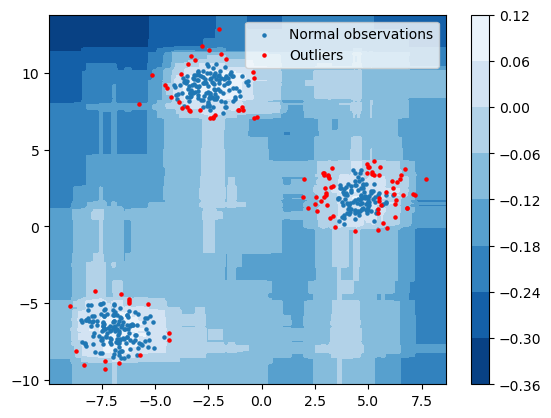

In [31]:
IF = IsolationForest(n_estimators = 10)

y_pred = IF.fit_predict(X)
X_outliers = X[y_pred == -1]
X_normal = X[y_pred == 1]

xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = IF.decision_function(grid).reshape(xx.shape)
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
plt.colorbar(z)
plt.legend()
plt.show()

The function's contours resemble rectangles because every tree split is parallel to one of the axis, and with a lower number of trees, the contours do not have the chance to smooth out. The countours slightly ressemble those of the KDE and OCSVM but they are not precisely equivalent. 

# Bonus Part ++ : Comparison of KDE, OCSVM, IF on real world data 

### Question 9

Compare these three algorithms on the dataset on the http dataset available http://odds.cs.stonybrook.edu/http-kddcup99-dataset/. Compare the accuracy of the algorithms with the roc curves and the computational time. 

In [32]:
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

#### Import data

In [33]:
!pip install mat73



In [34]:
import mat73
data = mat73.loadmat('http.mat')
X = data['X']
y_true = data['y']
print(len(X))
print(len(y_true))

567498
567498


In [73]:
# Given that OCSVM and KDE are omega(n^2) 
# we perform a train test split to have a smaller dataset
# but we still want stratification to preserve the ratio of anomalies

X_, _ , y_true_ ,__ = train_test_split(X, y_true, stratify=y_true, train_size = 0.010)

#### Perform algorithms and compute time

In [74]:
len(X_)
print(len(y_true_[y_true_ != 0]))

22


In [82]:
t1 = time.time()
if2 = IsolationForest(n_estimators = 10)
if2.fit(X_)
y_pred_IF = -if2.score_samples(X_)
t2 = time.time()
print(f"Isolation forests = {t2-t1} sec")

Isolation forests = 0.03787398338317871 sec


In [83]:
t1 = time.time()
ocsvm2 = OneClassSVM()
ocsvm2.fit(X_)
y_pred_OC = -ocsvm2.score_samples(X_)
t2 = time.time()
print(f"One class svm = {t2-t1} sec")

One class svm = 2.945482015609741 sec


In [84]:
t1 = time.time()
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.5)
y_pred_kde = kde2.fit(X_)
y_pred_kde = -kde2.score_samples(X_)
t2 = time.time()
print(f"KDE = {t2-t1} sec")

KDE = 2.0210249423980713 sec


In all three cases, we negate the classifier scores because bigger values in y_pred indicate not-an-outlier while the positive class (1, in y_true) means outlier. If we dont negate the y_pred, the algorithm will output the reflection around the x=y line of the actual curve. 

#### Display roc curves

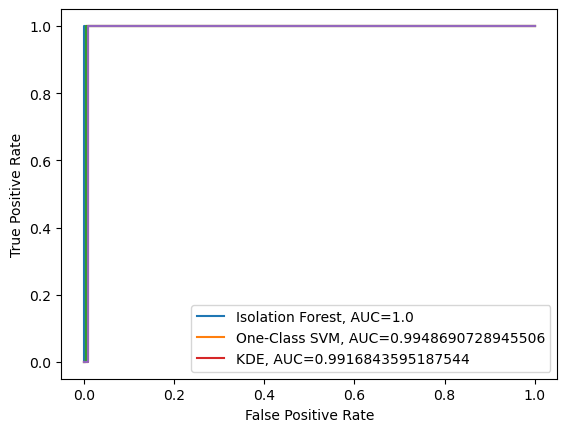

In [85]:
fpr, tpr, _ = roc_curve(y_true_,  y_pred_IF)
auc = roc_auc_score(y_true_,  y_pred_IF)
plt.plot(fpr,tpr, label="Isolation Forest, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y_true_,  y_pred_OC)
auc = roc_auc_score(y_true_,  y_pred_OC)
plt.plot(fpr,tpr, label="One-Class SVM, AUC="+str(auc))
plt.plot(fpr,tpr)

fpr, tpr, _ = roc_curve(y_true_,  y_pred_kde)
auc = roc_auc_score(y_true_,  y_pred_kde)
plt.plot(fpr,tpr, label="KDE, AUC="+str(auc))
plt.plot(fpr,tpr)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Question 10:

Repeat this comparison with other datasets from http://odds.cs.stonybrook.edu. Try a high dimensional dataset such as the one here http://odds.cs.stonybrook.edu/speech-dataset/. What do you observe?

In [94]:
import scipy.io 
data =  scipy.io.loadmat('speech.mat')
X_ = data['X']
y_true_ = data['y']
print(len(X_))
print(len(y_true_))

3686
3686


In [100]:
print(X.shape)

(3686, 400)


In [95]:
t1 = time.time()
if2 = IsolationForest(n_estimators = 10)
if2.fit(X_)
y_pred_IF = -if2.score_samples(X_)
t2 = time.time()
print(f"Isolation forests = {t2-t1} sec")

Isolation forests = 0.09818696975708008 sec


In [96]:
t1 = time.time()
ocsvm2 = OneClassSVM()
ocsvm2.fit(X_)
y_pred_OC = -ocsvm2.score_samples(X_)
t2 = time.time()
print(f"One class svm = {t2-t1} sec")

One class svm = 2.8134121894836426 sec


In [97]:
t1 = time.time()
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.5)
y_pred_kde = kde2.fit(X_)
y_pred_kde = -kde2.score_samples(X_)
t2 = time.time()
print(f"KDE = {t2-t1} sec")

KDE = 10.112078189849854 sec


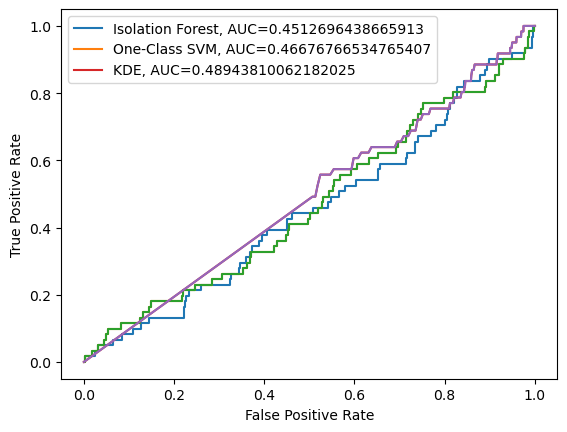

In [98]:
fpr, tpr, _ = roc_curve(y_true_,  y_pred_IF)
auc = roc_auc_score(y_true_,  y_pred_IF)
plt.plot(fpr,tpr, label="Isolation Forest, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y_true_,  y_pred_OC)
auc = roc_auc_score(y_true_,  y_pred_OC)
plt.plot(fpr,tpr, label="One-Class SVM, AUC="+str(auc))
plt.plot(fpr,tpr)

fpr, tpr, _ = roc_curve(y_true_,  y_pred_kde)
auc = roc_auc_score(y_true_,  y_pred_kde)
plt.plot(fpr,tpr, label="KDE, AUC="+str(auc))
plt.plot(fpr,tpr)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

We observe that our classifiers have been the unfortunate victims of the curse of dimensionality. The dataset speech had 400 parameters so our algorithms were not able handle the outlier separation. As consequence, we have the roc curve of a random decision classifier.